In [4]:
!python -m spacy download en_core_web_sm #trained using cnn

!python -m spacy download en_core_web_md #has word embedding (gloVe); trained using cnn

!python -m spacy download en_core_web_trf #everything is trained using transformer

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-02-05 03:27:45.442691: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 76.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-02-05 03:27:56.590862: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━

## 1. Loading Data

In [1]:
import pandas as pd
import numpy as np

df_resume = pd.read_csv("/content/resume.csv")

In [2]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000, ]  # optional if your computer is fast, no need
df_resume.shape

(1000, 4)

## 2. Loading Skill Data

In [5]:
import spacy

nlp = spacy.load('en_core_web_md')
skill_path = "/content/skills.jsonl"

In [6]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [7]:
doc = nlp("Chaky loves deep learning.")
doc.ents

(Chaky, deep learning)

## 3. Extracting Skills from resume.csv

In [8]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
391,17481570,ASSISTANT TEACHER Summary A...,"<div class=""fontsize fontface vmargins hmargin...",TEACHER
902,14107571,FLIGHT ATTENDANT Summary Fo...,"<div class=""fontsize fontface vmargins hmargin...",FITNESS
862,70603826,HEAD GIRLS BASKETBALL COACH ...,"<div class=""fontsize fontface vmargins hmargin...",FITNESS
2468,49646155,ENTREPRENEUR GENERAL MANAGER Su...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION
434,20478831,HOMEBOUND TEACHER Career Focus ...,"<div class=""fontsize fontface vmargins hmargin...",TEACHER


In [9]:
from spacy.lang.en.stop_words import STOP_WORDS

# before that, let's clean our resume.csv dataframe
def preprocessing(sentence):
    
    stopwords = list(STOP_WORDS)
    doc = nlp(sentence)
    cleaned_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SPACE' and \
            token.pos_ != 'SYM':
                cleaned_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(cleaned_tokens)

In [10]:
# random sampling
random_resume = df_resume.Resume_str.iloc[5]
random_resume[:300]

'         CONSULTANT       Summary    In-depth knowledge and understanding of numerous software packages and operating systems.\n     Skilled in Database Administrator, Network Administration, Web developer. Providing Customer and\n     End-User Help Desk Support. Easily identify and resolve technical '

In [11]:
preprocessing(random_resume[:300])

'consultant summary in depth knowledge understanding numerous software package operating system skilled database administrator network administration web developer provide customer end user help desk support easily identify resolve technical'

In [12]:
# let's apply to the whole dataframe
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

In [13]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume
391,17481570,ASSISTANT TEACHER Summary A...,"<div class=""fontsize fontface vmargins hmargin...",TEACHER,assistant teacher summary an organized profess...
902,14107571,FLIGHT ATTENDANT Summary Fo...,"<div class=""fontsize fontface vmargins hmargin...",FITNESS,flight attendant summary former police detecti...
862,70603826,HEAD GIRLS BASKETBALL COACH ...,"<div class=""fontsize fontface vmargins hmargin...",FITNESS,head girls basketball coach summary former col...
2468,49646155,ENTREPRENEUR GENERAL MANAGER Su...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION,entrepreneur general manager summary over 17 y...
434,20478831,HOMEBOUND TEACHER Career Focus ...,"<div class=""fontsize fontface vmargins hmargin...",TEACHER,homebound teacher career focus utilize skill t...


## 4. Let's really Extract Skills!!

In [14]:
def get_skills(text):
    # passing the text to the nlp
    doc = nlp(text)  # note that this nlp already know skills
    
    skills = []
    
    # looking at the ents
    for ent in doc.ents:
        # if the ent.label_ is SKILL, then we append to some list
        if ent.label_ == "SKILL":
            skills.append(ent.text)
    
    return skills

def unique_skills(x):
    return list(set(x))

In [15]:
df_resume.head(1)

,ID,Resume_str,Resume_html,Category,Clean_resume
391,17481570,ASSISTANT TEACHER Summary A...,"<div class=""fontsize fontface vmargins hmargin...",TEACHER,assistant teacher summary an organized profess...


In [16]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills)
df_resume['Skills'] = df_resume.Skills.apply(unique_skills)

In [17]:
df_resume.Skills.iloc[0]

['support']

## 5. Visualization

In [18]:
set(df_resume.Category)

{'ACCOUNTANT',
 'ADVOCATE',
 'AGRICULTURE',
 'APPAREL',
 'ARTS',
 'AUTOMOBILE',
 'AVIATION',
 'BANKING',
 'BPO',
 'BUSINESS-DEVELOPMENT',
 'CHEF',
 'CONSTRUCTION',
 'CONSULTANT',
 'DESIGNER',
 'DIGITAL-MEDIA',
 'ENGINEERING',
 'FINANCE',
 'FITNESS',
 'HEALTHCARE',
 'HR',
 'INFORMATION-TECHNOLOGY',
 'PUBLIC-RELATIONS',
 'SALES',
 'TEACHER'}

In [19]:
category = 'INFORMATION-TECHNOLOGY'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(54, 6)

In [20]:
all_skill = np.concatenate(df_resume_it.Skills.values)

In [21]:
# counting
from collections import Counter, OrderedDict

counting = Counter(all_skill)
counting = OrderedDict(counting.most_common(10))

In [22]:
counting

OrderedDict([('support', 49),
             ('software', 45),
             ('security', 36),
             ('design', 36),
             ('business', 36),
             ('server', 34),
             ('windows', 34),
             ('database', 28),
             ('project management', 22),
             ('documentation', 18)])

<BarContainer object of 10 artists>

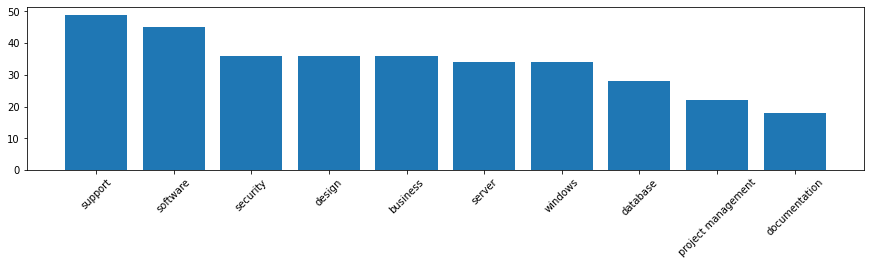

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.xticks(rotation =45)

plt.bar(counting.keys(), counting.values())

## 6. Name Entity Recognition

In [24]:
from spacy import displacy

text = df_resume_it.Clean_resume.iloc[43]

In [25]:
doc = nlp(text)

In [26]:
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [28]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options, jupyter=True)

## Let's Load the PDF (adding some realism)

In [30]:
!pip install PyPDF2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 KB 6.1 MB/s eta 0:00:00


In [31]:
from PyPDF2 import PdfReader
# pip install PyPDF2

reader = PdfReader("/content/someone_cv.pdf")
page = reader.pages[0] #first page just for demo
text = page.extract_text() 

In [32]:
text = preprocessing(text)

In [33]:
doc = nlp(text)

In [34]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options, jupyter=True)

In [35]:
# collecting all the skill and put it into a list

skills = []

for ent in doc.ents:
    if ent.label_ == 'SKILL':
        skills.append(ent.text)
        
print(set(skills))

{'engineering', 'deep learning', 'computer science', 'ai', 'algorithms'}
